**IMPORTS**

In [91]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
from scipy.signal import butter, lfilter
import soundfile as sf

**VARIABLES GLOBALES**

In [92]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']
audios           = {fruit: [] for fruit in fruit_types}
training_path    = '../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

**DICCIONARIO DE AUDIOS ORIGINALES**

In [95]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**DICCIONARIO DE AUDIOS PROCESADOS**

In [96]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**PARAMETROS DEL AUDIO**

In [97]:
FRAME_SIZE = 1024# In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

"FRAME_SIZE = 1024# In the documentation says it's convenient for speech.C\nHOP_SIZE   = int(FRAME_SIZE/2)"

**FUNCIONES GENERALES DE AUDIO**

In [99]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [101]:
def rms(signal, frames, hop):
    return librosa.feature.rms(y=signal, frame_length = frames, hop_length = hop)

**FILTERS**

In [104]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [105]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [106]:
def preemphasis(signal, coef=0.97):
    return np.append(signal[0], signal[1:] - coef * signal[:-1])

**PRROCCESSING OF THE AUDIO FILES FUNCTIONS**

In [110]:
def spectral_flux(signal):

    # Calcular el espectrograma de magnitudes
    spectrogram = np.abs(librosa.stft(signal, n_fft=512, hop_length=256))

    # Calcular el flujo espectral
    spectral_flux_values = np.sum(np.diff(spectrogram, axis=1)**2, axis=0)

    return spectral_flux_values

anda medio como el culo con las bananas y las naranjas

In [111]:
def process(audio_in, audio_out, rms_umbral = 0.043, flux_umbral = 0.096):
    signal, sr, duration = load_audio(audio_in)

    rms = librosa.feature.rms(y = signal, frame_length = 512, hop_length = 256)
    rms /= np.max(np.abs(rms))
    trms = librosa.times_like(rms, sr = sr, hop_length = 256, n_fft = 512)
    trms /= trms[-1]

    flux = spectral_flux(signal)
    flux /= np.max(np.abs(flux))
    fluxframes = range(len(flux))
    tflux = librosa.frames_to_time(fluxframes, hop_length=256, n_fft = 512)
    tflux /= tflux[-1]
                
    left_index = np.argmax(np.abs(flux) > flux_umbral)
    rigth_index = len(flux) - 1 - np.argmax(np.abs(np.flip(flux)) > flux_umbral)

    tsignal = librosa.times_like(signal, sr = sr, hop_length=256, n_fft=512)
    tsignal /= tsignal[-1]

    flag      = False
    pad_left  = 0
    pad_rigth = 0
    flag_left  =  False
    flag_rigth =  False
                
    while not flag:
        if rms[0, left_index] > rms_umbral:
            if left_index > pad_left + 15:
                rms_left = left_index - np.argmax(np.flip(np.abs(rms[0, :left_index]) < rms_umbral))
                if rms_left <= 0:
                    rms_left = left_index
                flag_left = True
            else:
                pad_left += 15
                left_index = pad_left + np.argmax(np.abs(flux[pad_left:]) > flux_umbral)
        else:
                rms_left = left_index
                flag_left = True

        if rms[0, rigth_index] > rms_umbral:
            if rigth_index < (len(flux) - 1 - pad_rigth-15):
                rms_rigth = rigth_index + np.argmax(np.abs(rms[0, rigth_index:]) < rms_umbral)
                if rms_rigth >= rms.shape[1]:
                    rms_rigth = rigth_index
                flag_rigth = True
            else:
                pad_rigth += 15
                rigth_index = len(flux[:-pad_rigth]) - 1 - np.argmax(np.flip(np.abs(flux[:-pad_rigth]) > flux_umbral))                               
        else:
            rms_rigth = rigth_index
            flag_rigth = True

        flag = flag_left and flag_rigth

    left_index  = min(left_index, rms_left)
    rigth_index = max(rigth_index, rms_rigth)

    mask = tsignal >= tflux[left_index]
    ttrimed = tsignal[mask]
    trimed = signal[mask]
    mask = ttrimed <= tflux[rigth_index]
    ttrimed = ttrimed[mask]
    trimed = trimed[mask]
    sf.write(audio_out, trimed, sr)

In [ ]:
def process_audios(original:dict, processed:dict):
    already_processed = []
    for group in processed.values():
        already_processed.extend([os.path.basename(audio) for audio in group])
        
    for fruit, audios in original.items():
        for audio in audios:
            file = os.path.basename(audio)
            if file in already_processed:
                pass
            else:
                audio_out = os.path.join(processed, f"{fruit}/{file}")
                process(audio, audio_out)
                processed[fruit].append(audio_out)

**PLOTTING**

In [116]:
#3d
def plot_features3d(features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))

    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

**AUDIO PROCESSING**

In [117]:
process_audios(original, processed)

'process_audios(original, processed)'

**FEATURES EXTRACTION**

*Features extraction function*

In [119]:
def get_features(signal, sr, duration):
    cuton = 20
    cutoff = 8500
    n_mfcc = 4
    feature = np.empty((1, 0))

    # Envelope RMS
    smoothed = librosa.feature.rms(y = signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)
    smoothed = smoothed.reshape(-1,)
    smoothed /= np.max(np.abs(smoothed))

    #std
    feat = np.std(np.abs(smoothed))/np.mean(np.abs(smoothed))
    feature = np.append(feature, feat)

    #ZCR
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    #maximum
    feat = np.max(zcr[((len(zcr)*4)//5 - 5) : ((len(zcr)*4)//5 + 5)])
    feature = np.append(feature, feat)
    zcr /= np.max(np.abs(zcr))
    #mean
    feat = np.mean(zcr[((len(zcr)*2)//7 - 5) : ((len(zcr)*2)//7 + 5)])
    feature = np.append(feature, feat)
    #std
    feat = np.std(zcr)/np.mean(zcr)
    feature = np.append(feature, feat)

    #MFCCS
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    #maximum
    feat = np.max(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[3]
    feature = np.append(feature, feat)
            
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

    #std
    feat = np.std(mfccs, axis = 1)/np.mean(mfccs, axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)

    #momentum
    frames = range(mfccs.shape[1])
    t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
    feat = feat[0]
    feature = np.append(feature, feat)
    feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)

    selected = np.linspace(0, len(smoothed) - 1, 30, dtype=int)
    env = smoothed[selected]
    env = env.reshape(-1,1)
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)

    return feature

*Extraction of features from processed audios*

In [120]:
def extract_features(processed:dict):
    features = dict.fromkeys(fruit_types)
    for fruit, audios in processed.items():
        features[fruit] = None
        
        for audio in audios:
            # Load the audio signal
            signal, sr, duration = load_audio(audio)
            feature = get_features(signal, sr, duration)
        
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    return features

**Training audios features extraction**

In [121]:
features = extract_features(processed)

'features = extract_features(processed)'

**PCA**

In [123]:
#PCA and dump
whole            = np.concatenate(list(features.values()), axis=0)

#Aplicar PCA para obtener dos componentes principales
pca              = PCA(n_components = 3)
scaler           = StandardScaler()
whole_scaled     = scaler.fit_transform(whole)
reduced_features = pca.fit_transform(whole_scaled)

**REDUCED MODEL**

In [124]:
#Paso 3: Crear un diccionario con las matrices reducidas
reduced = {}
start_idx = 0

for fruit, matrix in features.items():
    num_rows = matrix.shape[0]
    reduced[fruit] = reduced_features[start_idx:start_idx + num_rows, :]
    start_idx += num_rows

**Dumping to file**

In [125]:
model['pca']      = pca
model['features'] = reduced
model['scaler']   = scaler
joblib.dump(model, model_file)

['model.pkl']

**PLOTTING**

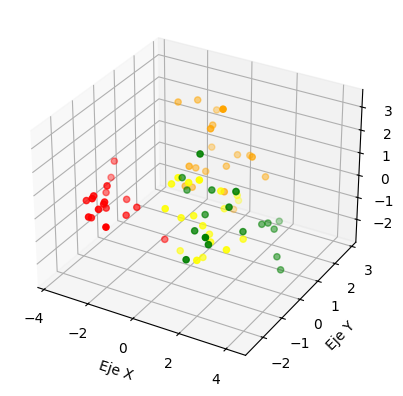

In [126]:
plot_features3d(reduced)